In [3]:
import numpy as np
import pandas as pd
import scipy.optimize
from scipy import stats

import powerlaw
import pickle5 as pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Unpickling the data
def load_obj(name):
    with open('resources/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [71]:
# Bus adjacency
def bus_adjacency(stoproute,lsoa_list,route_freqs):
    
    # Create matrix that combines location data and route frequencies
    combine = pd.merge(stoproute, route_freqs, on='line')
    combine = combine.drop_duplicates(['line', 'naptan_sto'])
    combine = combine.rename(columns={'geo_code':'lsoa11cd'})

    # Create adjacency matrix LSOA x route
    bstopfreq = combine[['lsoa11cd', 'naptan_sto', 'line', 'average']]
    adj = pd.pivot(bstopfreq,index=["lsoa11cd", "naptan_sto"], columns="line", values="average").fillna(0)
    adj = adj.astype(float)
    adj = adj.groupby(level="lsoa11cd").mean()
    bus2route = pd.merge(lsoa_list, adj, how='left',on='lsoa11cd').set_index('lsoa11cd')

    #Adjacency matrix LSOA x LSOA
    bus2route = np.array(bus2route)
    bus2routeT = bus2route.transpose()
    lsoa2lsoa = np.dot(bus2route,bus2routeT)**0.5 #check that this actually does whay I think it does
    lsoa2lsoa[np.diag_indices_from(lsoa2lsoa)] = 0

    lsoa2lsoa = pd.DataFrame(lsoa2lsoa)
    lsoa2lsoa = lsoa2lsoa.fillna(0)

    m values created - changed bit of code 
    m_bus = np.round(lsoa2lsoa.copy(),0)
    m_bus[m_bus>0]=np.log10(m_bus[m_bus>0])
    m_bus=1-(m_bus/np.max(np.max(m_bus)))
    m_bus[m_bus==0]=np.min(np.min(m_bus[m_bus!=0]))
    
    # initial bit of code - gives values over 1 as max
#     m_bus = lsoa2lsoa.copy()
#     m_bus[m_bus>0]=np.log10(m_bus[m_bus>0])
#     m_bus=1-(m_bus/np.max(np.max(m_bus)))
    
    return m_bus.values

# Attractivity samples - median/neighbourhood, directional 
def attractivity_median_sampler(oa, edu_ratios, income_params, size):
   
    edu = np.random.choice(4, size = size, p=edu_ratios[oa]) #where p values are effectively the ratio of people with a given education level
    income = stats.beta.rvs(income_params[oa, 0], income_params[oa, 1], loc = income_params[oa, 2], scale = income_params[oa, 3], size=size)

    attractivity = np.power(income, -edu)

    return np.median(attractivity)



# Median att matrix 
def median_attractivity(edu_ratios, income_params): #,fit = None):

    """
    Average individual attractivity / lsoa (taken as a sample of 1000 ppl)
    Sample is directinal - matrix not symmetrical
    """

    attractivity = np.zeros((len(income_params)))
    size = 10000

    for i in range(len(income_params)):
        attractivity[i] = attractivity_median_sampler(i, edu_ratios, income_params, size)

    attractivity = attractivity.reshape((len(attractivity),1))

    return attractivity



In [72]:
test=bus_adjacency(stoproute, lsoa_list, route_freqs)

np.max(test)

/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


1.6065672400773927

/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

<AxesSubplot:ylabel='Density'>

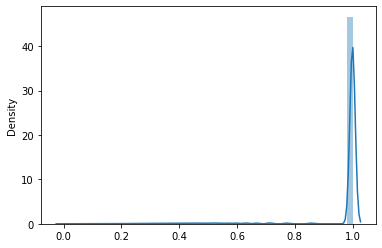

In [67]:
test=bus_adjacency(stoproute, lsoa_list, route_freqs)
np.max(test)
sns.distplot(test)

# Turning objective in a linear function - use 'linprog' for optimisation

Be careful with var shapes and how they convert - keep track of positions

In [322]:
# Example problem 
import numpy as np
from scipy.optimize import linprog

# function - in my case A 
c = np.array([-29.0, -45.0, 0.0, 0.0])

# inequality constraint - has to be in the form less than 
A_ub = np.array([[1.0, -1.0, -3.0, 0.0],
                [-2.0, 3.0, 7.0, -3.0]])
b_ub = np.array([5.0, -10.0])

# equality constraint
A_eq = np.array([[2.0, 8.0, 1.0, 0.0],
                [4.0, 4.0, 0.0, 1.0]])
b_eq = np.array([60.0, 60.0])

x0_bounds = (0, None)
x1_bounds = (0, 6)
x2_bounds = (-np.inf, 0.5)  # +/- np.inf can be used instead of None
x3_bounds = (-3.0, None)

bounds = [x0_bounds, x1_bounds, x2_bounds, x3_bounds]

result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
print(result)

     con: array([9.79128600e-09, 1.04691367e-08])
     fun: -505.97435889011126
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([ 6.52783605e-10, -2.26780017e-09])
  status: 0
 success: True
       x: array([ 9.41025641,  5.17948718, -0.25641026,  1.64102564])


In [122]:
bounds

[(0, None), (0, 6), (-inf, 0.5), (-3.0, None)]

In [195]:
a = [1 for i in range(10)]
b = [0 for i in range(10)]
list(zip(a,b))

[(1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0)]

## Loading in input data

In [8]:
# attractivity product
lsoa_data = load_obj("newdata_lsoa_data")
sheff_shape, income_params, edu_counts, edu_ratios = lsoa_data['sheff_lsoa_shape'], lsoa_data['income_params'], lsoa_data['edu_counts'], lsoa_data['edu_ratios']
comp_ratio = np.load("resources/newdata_companyhouse.npy")
attractivity_avg = median_attractivity(edu_ratios, income_params)
attractivity_product = np.matmul(attractivity_avg, attractivity_avg.transpose())
attractivity_product = np.multiply(attractivity_product, comp_ratio)

pop = np.asarray(edu_counts).reshape((len(edu_counts), 1))
pop = np.matmul(pop, pop.transpose())

attractivity_product = np.multiply(attractivity_product, pop)
    
# distances
paths_matrix = load_obj("newdata_ave_paths")
# removes all 0s not on the diag 
paths_matrix[paths_matrix==0] = 1
paths_matrix[np.diag_indices_from(paths_matrix)] = 0
    
# bus network
stoproute = pd.read_csv('resources/stoproute_withareacodes.csv')
lsoa_list = pd.read_csv("resources/E47000002_KS101EW.csv")['lsoa11cd']
route_freqs = pd.read_csv('resources/Bus_routes_frequency.csv', usecols= ["line","average"]).astype(str)
m_paths = bus_adjacency(stoproute, lsoa_list, route_freqs)
    

/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/ioana.jelea/opt/anaconda3/envs/lsoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


In [66]:
import numpy as np
from scipy.optimize import linprog
# from scipy.optimize import Bounds

n=50
att_p = attractivity_product[0:n,0:n]
paths_mat = paths_matrix[0:n,0:n]
m_pat = m_paths[0:n,0:n]

paths_mat = np.reshape(paths_mat,(len(paths_mat)**2,1))
m_pat = np.reshape(m_pat,(len(m_pat)**2,1))

# function - in my case A 
c = - np.reshape(att_p,(1,len(att_p)**2))

# inequality constraint - has to be in the form less than 
# A_ub = np.array([[ 1/len(m_pat) for i in range(len(m_pat))]])
A_ub = np.array([[ 1 for i in range(len(m_pat))]])


b = np.reshape(np.power(paths_mat,- m_pat),(len(m_pat),1))
b[np.where(np.isinf(b))[0], np.where(np.isinf(b))[1]] = 0
# b_ub = np.array([[np.mean(b_ub)]])
b_ub = np.array([[np.sum(b)]])

# bounds have been checked for shape 
bl = np.array([1/paths_mat[i] for i in range(len(paths_mat))])
bl[np.where(np.isinf(bl))[0], np.where(np.isinf(bl))[1]] = 0
bl = bl.flatten()
bl = bl.tolist()

bu = np.ones_like(paths_mat)
bu = bu.flatten()
bu = bu.tolist()

bounds = list(zip(bl,bu))


result = linprog(c, A_ub=A_ub, b_ub=b_ub[0], bounds=bounds)
print(result)

/var/folders/9v/cwjxgbc17v9gt368p99ndkw80000gn/T/ipykernel_97937/460277127.py:21: RuntimeWarning: divide by zero encountered in power
  b = np.reshape(np.power(paths_mat,- m_pat),(len(m_pat),1))
/var/folders/9v/cwjxgbc17v9gt368p99ndkw80000gn/T/ipykernel_97937/460277127.py:27: RuntimeWarning: divide by zero encountered in true_divide
  bl = np.array([1/paths_mat[i] for i in range(len(paths_mat))])


     con: array([], dtype=float64)
     fun: -24054624451.413742
 message: 'The algorithm terminated successfully and determined that the problem is unbounded.'
     nit: 11
   slack: array([-58.5775306])
  status: 3
 success: False
       x: array([0.00159132, 0.00366594, 0.0030547 , ..., 0.0026305 , 0.00932276,
       0.82751083])


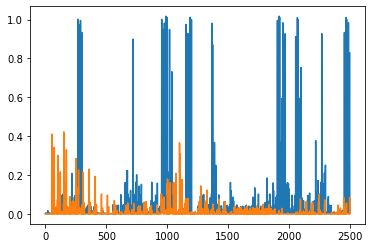

In [61]:
plt.plot(result.x)
plt.plot(b)

In [62]:
np.sum(result.x) - b_ub[0]

array([58.5775306])